### <b>Dataset Download</b>

* This facial identity classification dataset has total <b>307 identities</b>. (train: 4,263 / test: 1,215)
* <b>Original dataset</b>: [CelebA Mask HQ](https://github.com/switchablenorms/CelebAMask-HQ)

<pre>
<b>Dataset/</b>
    <b>train/</b>
        identity 1/
        identity 2/
        ...
    <b>test/</b>
        identity 1/
        identity 2/
        ...
</pre>

### <b>Load Dataset</b>

* Set the image directory path and initialize PyTorch data loaders.

## Data Augmentation for transfer learning

Because the faces provided in the Youtube Faces dataset is aligned, we apply random rotation to the images for better results during inference.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os

batch_size = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

### Define Sampler

In [2]:
from torch.utils.data.sampler import RandomSampler

transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(50), # added
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.CenterCrop(160),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.CenterCrop(160),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/home/ubuntu/visual_search_assistant/youtube_split_'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)


In [3]:
train_size = len(train_dataset)
test_size = len(test_dataset)

train_indices = list(range(train_size))
test_indices = list(range(test_size)) 

np.random.shuffle(train_indices)
np.random.shuffle(test_indices)

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

train_subset_size = 30000
test_subset_size = 1000

train_sampler = SubsetRandomSampler(train_indices[:train_subset_size])
test_sampler = SubsetRandomSampler(test_indices[:test_subset_size])

# train_sampler = None
# test_sampler = None

In [4]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0,sampler=train_sampler)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=0,sampler=test_sampler)

# print('Train dataset size:', len(train_dataset))
# print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
print('First 200 Class names:', class_names[:200])

First 200 Class names: ['AJ_Cook', 'Aaron_Eckhart', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abba_Eban', 'Abdel_Aziz_Al-Hakim', 'Abdoulaye_Wade', 'Abdulaziz_Kamilov', 'Abdullah_Gul', 'Abdullatif_Sener', 'Abel_Pacheco', 'Adam_Ant', 'Adam_Sandler', 'Adrian_Nastase', 'Adrianna_Zuzic', 'Agbani_Darego', 'Agnes_Bruckner', 'Ahmad_Masood', 'Ahmed_Ahmed', 'Aidan_Quinn', 'Aishwarya_Rai', 'Akbar_Al_Baker', 'Akiko_Morigami', 'Akmal_Taher', 'Al_Davis', 'Al_Gore', 'Al_Leiter', 'Al_Pacino', 'Alan_Ball', 'Alan_Dershowitz', 'Alanis_Morissette', 'Alastair_Campbell', 'Albert_Brooks', 'Alberto_Acosta', 'Alberto_Gonzales', 'Alberto_Ruiz_Gallardon', 'Alec_Baldwin', 'Alejandro_Gonzalez_Inarritu', 'Alejandro_Toledo', 'Alek_Wek', 'Aleksander_Kwasniewski', 'Alex_Ferguson', 'Alex_Holmes', 'Alex_Sink', 'Alexander_Downer', 'Alexander_Lukashenko', 'Alexander_Payne', 'Alexandra_Pelosi', 'Alexandre_Despatie', 'Alexandre_Herchcovitch', 'Alexis_Bledel', 'Alexis_Dennisoff', 'Alfonso_Cuaron', 'Alfred_Sant', 'Alfredo_Moreno', 'Al

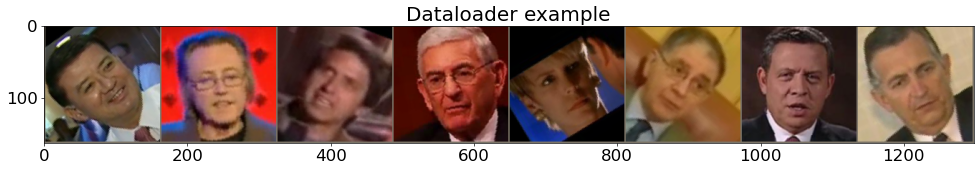

['Eric_Shinseki', 'Christopher_Walken', 'Ray_Romano', 'Eli_Broad', 'Jamie_Lee_Curtis', 'Rocco_Buttiglione', 'King_Abdullah_II', 'Edward_Seaga']


In [5]:
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)

demo_count = 8
out = torchvision.utils.make_grid(inputs[:demo_count])
imshow(out,title='Dataloader example')
print([class_names[x] for x in classes[:demo_count]])

### <b>Define Model</b>

* We focus on a transfer learning method.

In [11]:
from facenet_pytorch import InceptionResnetV1

model = InceptionResnetV1(pretrained='vggface2',num_classes=1004,classify=True).to(device)

# model = InceptionResnetV1(num_classes=1004,classify=True).to(device)

In [7]:
# model = models.resnet18(pretrained=True)
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 307) # multi-class classification (num_of_class == 307)
# model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.008, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.9, patience=1, min_lr=1e-8
        )

### <b>Training Phase</b>


In [8]:
torch.cuda.empty_cache()
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from tqdm import tqdm
from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True
import warnings
warnings.filterwarnings('ignore')

num_epochs = 30
start_time = time.time()

for epoch in range(num_epochs):
    """ Training Phase """
    model.train()

    running_loss = 0.
    running_corrects = 0
    # load a batch data of images
    for i, (inputs, labels) in tqdm(enumerate(train_dataloader)):
#         import pdb;pdb.set_trace()
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / train_subset_size
    epoch_acc = running_corrects / train_subset_size * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Test Phase """
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / test_subset_size
        epoch_acc = running_corrects / test_subset_size * 100.
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))
        scheduler.step(epoch_acc)

469it [04:10,  1.87it/s]


[Train #0] Loss: 2.2098 Acc: 66.6700% Time: 250.5906s
[Test #0] Loss: 3.6963 Acc: 37.4000% Time: 255.5265s


469it [03:56,  1.98it/s]


[Train #1] Loss: 0.4102 Acc: 94.7200% Time: 492.0289s
[Test #1] Loss: 2.9500 Acc: 47.2000% Time: 496.4792s


469it [03:56,  1.98it/s]


[Train #2] Loss: 0.1197 Acc: 98.9700% Time: 733.1180s
[Test #2] Loss: 2.6787 Acc: 50.9000% Time: 737.5832s


469it [03:57,  1.98it/s]


[Train #3] Loss: 0.0462 Acc: 99.7533% Time: 974.6077s
[Test #3] Loss: 2.5932 Acc: 50.9000% Time: 979.1536s


469it [03:57,  1.97it/s]


[Train #4] Loss: 0.0269 Acc: 99.8633% Time: 1216.7358s
[Test #4] Loss: 2.5765 Acc: 51.7000% Time: 1221.1894s


469it [03:57,  1.98it/s]


[Train #5] Loss: 0.0190 Acc: 99.9200% Time: 1458.6094s
[Test #5] Loss: 2.5137 Acc: 53.2000% Time: 1463.0741s


469it [03:57,  1.98it/s]


[Train #6] Loss: 0.0143 Acc: 99.9467% Time: 1700.1310s
[Test #6] Loss: 2.4913 Acc: 53.3000% Time: 1704.6011s


469it [03:57,  1.97it/s]


[Train #7] Loss: 0.0109 Acc: 99.9467% Time: 1942.3445s
[Test #7] Loss: 2.4813 Acc: 53.0000% Time: 1946.7980s


87it [00:44,  1.96it/s]


KeyboardInterrupt: 

### <b>Final Test Phase</b>

* Save the trained model file.

In [9]:
save_path = 'finetuned_youtube_best.pth'
torch.save(model.state_dict(), save_path)

* Load from the trained model file.

In [ ]:
# model = models.resnet18(pretrained=True)
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 307) # multi-class classification (num_of_class == 307)
# model.load_state_dict(torch.load(save_path))
model.to(device)

* Evaluate the trained model.

[Original Image Examples]


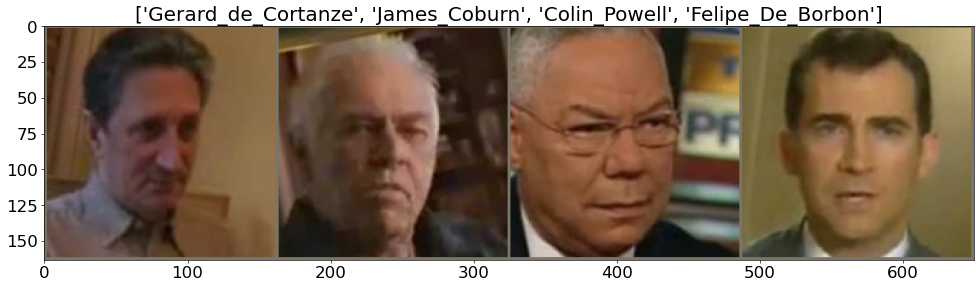

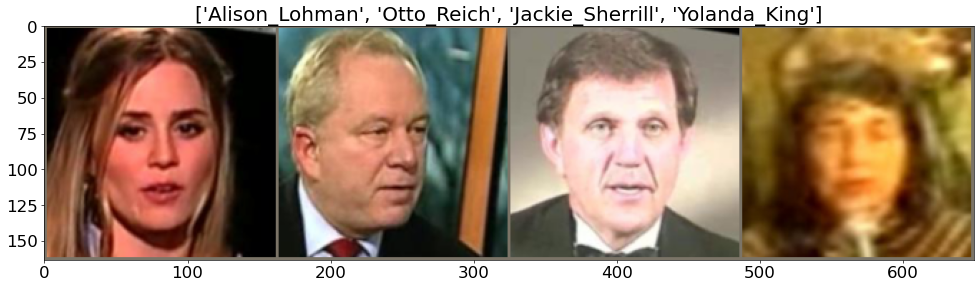

[Prediction Result Examples]


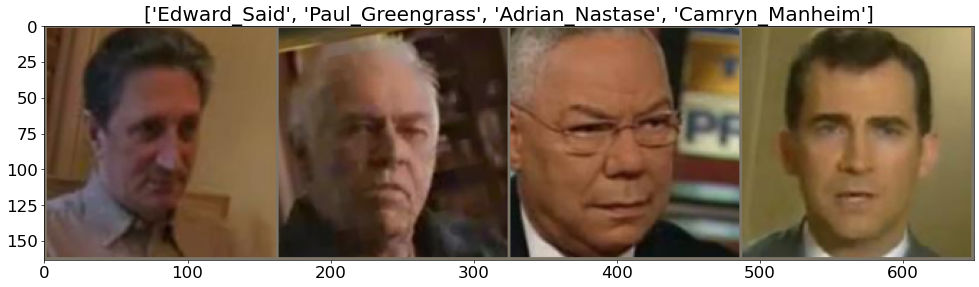

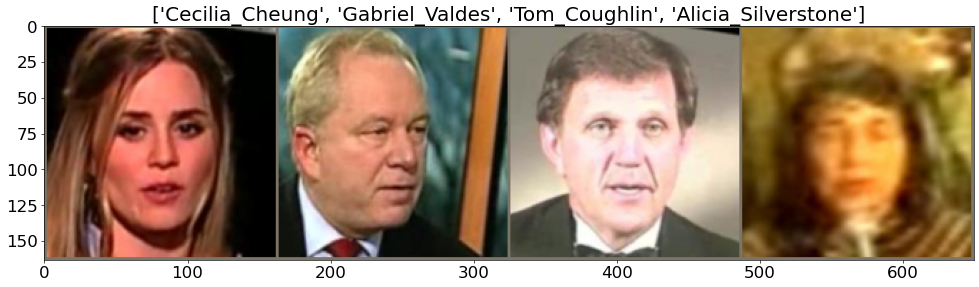

[Test #8] Loss: 7.0417 Acc: 0.2000% Time: 5.8257s


In [12]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Original Image Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in preds[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in preds[4:8]])

    epoch_loss = running_loss / test_subset_size
    epoch_acc = running_corrects / test_subset_size * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))